# Rozhodovací stromy: učení se z dat
  
  * V tomto notebooku byste se měli naučit, jak vytvořit (naučit) model dat ve formě rozhodovacího stromu.
  * Ukážeme si typický způsob, jak se toto dělá a představíme si i základní API knihovny `sklearn`.
  * Začneme s daty a skončíme s naučeným modelem, o kterém budeme tušit, jak je dobrý.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import math
import pandas as pd
import numpy as np

## Data: základní přehled

  * Použijeme balíček `pandas` k nahrání dat a jejich základnímu prozkoumání.
  * Data jsme stáhli ze serveru **kaggle.com**, kde můžete také najít [popis jednotlivých příznaků](https://www.kaggle.com/uciml/adult-census-income).

In [3]:
data = pd.read_csv('adult-census.csv')
display(data.shape)
display(data.head(10))
display(data.info())
display(data.describe())
display(data.nunique()) # počet unikátních hodnot, defaultně ignoruje NaNs

(32561, 15)

age    workclass  fnlwgt     education  education.num marital.status  \
0   90            ?   77053       HS-grad              9        Widowed   
1   82      Private  132870       HS-grad              9        Widowed   
2   66            ?  186061  Some-college             10        Widowed   
3   54      Private  140359       7th-8th              4       Divorced   
4   41      Private  264663  Some-college             10      Separated   
5   34      Private  216864       HS-grad              9       Divorced   
6   38      Private  150601          10th              6      Separated   
7   74    State-gov   88638     Doctorate             16  Never-married   
8   68  Federal-gov  422013       HS-grad              9       Divorced   
9   41      Private   70037  Some-college             10  Never-married   

          occupation    relationship   race     sex  capital.gain  \
0                  ?   Not-in-family  White  Female             0   
1    Exec-managerial   Not-in-family  White  Female             0   
2                  ?       Unmarried  Black  Female             0   
3  Machine-op-inspct       Unmarried  White  Female             0   
4     Prof-specialty       Own-child  White  Female             0   
5      Other-service       Unmarried  White  Female             0   
6       Adm-clerical       Unmarried  White    Male             0   
7     Prof-specialty  Other-relative  White  Female             0   
8     Prof-specialty   Not-in-family  White  Female             0   
9       Craft-repair       Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country income  
0          4356              40  United-States  <=50K  
1          4356              18  United-States  <=50K  
2          4356              40  United-States  <=50K  
3          3900              40  United-States  <=50K  
4          3900              40  United-States  <=50K  
5          3770              45  United-States  <=50K  
6          3770              40  United-States  <=50K  
7          3683              20  United-States   >50K  
8          3683              40  United-States  <=50K  
9          3004              60              ?   >50K

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


None

age        fnlwgt  education.num  capital.gain  capital.loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours.per.week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

age                  73
workclass             9
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           15
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       42
income                2
dtype: int64

### Chybějící hodnoty

  * Některé příznaky jsou očividně nevyplněné, ale `pandas` hlásí, že žádné nechybí. Je to tím, že chybějící hodnoty nejsou zakódované jako `NaN` ale jsou nahrazeny otazníkem `?`.

In [6]:
data = data.replace('?', np.nan)
# podívejme se na výsledek
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

## První pokus o použití rozhodovacího stromu implementovaného v `sklearn`

    

 * [Zde](http://scikit-learn.org/stable/modules/tree.html) najdete dokumentaci k rozhodovacím stromům v balíčku `tree` knihovny `scikit-learn`.
 * Naším cílem je pouze zjistit, jestli už máme data připravená k tomu, aby si s nimi tato implementace poradila.

In [7]:
from sklearn.tree import DecisionTreeClassifier
# uložíme si vysvětlovanou proměnnou (poslední sloupec income) a příznaky
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1] 

  * V knihovně `scikit-learn` mají modely jednotný interface (API).
  * Nejdříve se vždy nastaví hyperparametry modelu (jaké jsou k dispozici lze zjistit pomocí nápovědy) a "nastavený" model se uloží do proměnné.
  * Model se pak "naučí" na datech pomocí metody `.fit()`. 
  * V případě supervizovaných modelů vyžaduje většinou matici (`pandas.DataFrame`) s příznaky a vektor (`pandas.Series`) s vysvětlovanou proměnnou.

In [11]:
dt = DecisionTreeClassifier()
#dt.get_params(True)

In [12]:
#dt.fit(Xdata, ydata)

  * **Ajajaj, nefunguje to:** implementace rozhodovacího stromu v `sklearn` si neumí poradit s nečíselnými (nenumerickými) příznaky.
  * Musíme proto nahradit stringy nějakými jejich kódy.
  * **ÚKOL:** Zjistěte, jaký je vztah mezi příznaky *education* a *education.num*. 

In [14]:
### sem přijde Váš kód
edu = data[["education", "education.num"]].drop_duplicates()
edu.sort_values(by="education.num")
# příp. i s počty:
#data.sort_values(by="education.num").groupby(by=["education", "education.num"])["education", "education.num"].count().sort_index(level=1)

education  education.num
1106     Preschool              1
26         1st-4th              2
27         5th-6th              3
3          7th-8th              4
197            9th              5
6             10th              6
16            11th              7
178           12th              8
0          HS-grad              9
2     Some-college             10
25       Assoc-voc             11
18      Assoc-acdm             12
12       Bachelors             13
13         Masters             14
11     Prof-school             15
7        Doctorate             16

In [15]:
display(data.dtypes)
display(data.nunique()) # number of uniques: Count number of distinct elements in specified axis.
string_cols = data.select_dtypes(['object']).columns
print(string_cols)
data[string_cols].nunique()

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

age                  73
workclass             8
fnlwgt            21648
education            16
education.num        16
marital.status        7
occupation           14
relationship          6
race                  5
sex                   2
capital.gain        119
capital.loss         92
hours.per.week       94
native.country       41
income                2
dtype: int64

Index(['workclass', 'education', 'marital.status', 'occupation',
       'relationship', 'race', 'sex', 'native.country', 'income'],
      dtype='object')


workclass          8
education         16
marital.status     7
occupation        14
relationship       6
race               5
sex                2
native.country    41
income             2
dtype: int64

  * Všechny příznaky s hodnotami typu string nejsou spojité, ale tzv. **kategorické** (diskrétní).
  * Můžeme je tedy všechny nahradit číselnými kódy.
  * Je v `pandas` nějaká metoda, která to umí? Samozřejmě ano. Je ale nutné typ příznaku v `pandas` změnit na `category`.

In [20]:
data[string_cols] = data[string_cols].astype('category').apply(lambda x: x.cat.codes)
#data[string_cols] = data[string_cols].apply(lambda x: x.cat.codes)
# na kategoricke sloupce pouzijeme metodu apply: Apply a function along an axis of the DataFrame.
# Series.cat.codes: Return Series of codes as well as the index.
data.info()
# funguje to?
data["native.country"].unique()
display(data.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  int8 
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  int8 
 4   education.num   32561 non-null  int64
 5   marital.status  32561 non-null  int8 
 6   occupation      32561 non-null  int8 
 7   relationship    32561 non-null  int8 
 8   race            32561 non-null  int8 
 9   sex             32561 non-null  int8 
 10  capital.gain    32561 non-null  int64
 11  capital.loss    32561 non-null  int64
 12  hours.per.week  32561 non-null  int64
 13  native.country  32561 non-null  int8 
 14  income          32561 non-null  int8 
dtypes: int64(6), int8(9)
memory usage: 1.8 MB


age  workclass  fnlwgt  education  education.num  marital.status  \
0   90          0   77053         11              9               6   
1   82          4  132870         11              9               6   
2   66          0  186061         15             10               6   
3   54          4  140359          5              4               0   
4   41          4  264663         15             10               5   
5   34          4  216864         11              9               0   
6   38          4  150601          0              6               5   
7   74          7   88638         10             16               4   
8   68          1  422013         11              9               0   
9   41          4   70037         15             10               4   

   occupation  relationship  race  sex  capital.gain  capital.loss  \
0           0             1     4    0             0          4356   
1           4             1     4    0             0          4356   
2           0             4     2    0             0          4356   
3           7             4     4    0             0          3900   
4          10             3     4    0             0          3900   
5           8             4     4    0             0          3770   
6           1             4     4    1             0          3770   
7          10             2     4    0             0          3683   
8          10             1     4    0             0          3683   
9           3             4     4    1             0          3004   

   hours.per.week  native.country  income  
0              40              39       0  
1              18              39       0  
2              40              39       0  
3              40              39       0  
4              40              39       0  
5              45              39       0  
6              40              39       0  
7              20              39       1  
8              40              39       0  
9              60               0       1

  * A teď to můžeme zkusit s `DecisionTreeClassifier` znovu!
  * Co se stalo s `NaN` položkami?

In [21]:
#data.occupation.unique()
data.groupby(["occupation"]).size() # ve sloupci occupation bylo 1843 chybějících hodnot --> hodnota -1

occupation
0     1843
1     3770
2        9
3     4099
4     4066
5      994
6     1370
7     2002
8     3295
9      149
10    4140
11     649
12    3650
13     928
14    1597
dtype: int64

**Chybějící hodnoty byly nahrazeny -1!**

Jak se vypořádat s chybějícími hodnotami je docela věda. Jejich nahrazení jedinou unikátní hodnotou je takový nejjednodušší (a skutečně používaný) způsob.

In [22]:
Xdata = data.iloc[:,:-1]
ydata = data.iloc[:,-1]
dt = DecisionTreeClassifier()
dt.fit(Xdata, ydata)
#dt.get_params(True)

DecisionTreeClassifier()

## Učení stromu

  * Cílem je vytvořit rozhodovací strom, který bude předpovídat *income* daných osob.
  * Chceme také najít nejlepší hodnoty parametrů `max_depth` a `criterion` metody `DecisionTreeClassifier`. Takovýmto parametrům metody se říká *hyperparametery*.
  * Jak víme z přednášky, správný způsob ladění hyperparametrů vyžaduje rozdělení dat na trénovací, validační a testovací.
  * A samozřejmě v `sklearn` je na to balíček.

In [23]:
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xtest.shape)
display(ytest.shape)

(24420, 14)

(24420,)

(8141, 14)

(8141,)

In [24]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
display(Xtrain.shape)
display(ytrain.shape)
display(Xval.shape)
display(yval.shape)

(18315, 14)

(18315,)

(6105, 14)

(6105,)

### Měření trénovací chyby pomocí klasifikační přesnosti

In [25]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(Xtrain, ytrain)
dt.get_params(True)

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

  * Rozhodovací strom máme hotový, nyní můžeme použít metodu `predict()`, abychom získali predikce, které dává strom pro trénovací data.

In [26]:
ypredicted = dt.predict(Xtrain)
ypredicted

array([0, 0, 0, ..., 0, 0, 1], dtype=int8)

In [29]:
(ytrain - ypredicted).value_counts(normalize=True) # normalizace na 1, False - pocty

0    0.999945
1    0.000055
Name: income, dtype: float64

  * Přesnost na trénovacích datech je  (pro `max_depth` = 50) skoro 100 %! 
  * Měřit přesnost a různé metriky nemusíme takto ručně, v `sklearn` je na to samozřejmě balíček:

In [30]:
import sklearn.metrics as metrics
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))

accuracy score (train): 0.999945


S testovacími daty to tak skvěle nedopadne:

In [31]:
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.814888


### Ladění hyperparameterů `max_depth` a `criterion`

  * Začněme s hyperparametrem `max_depth`.
  * Jak víme, budeme používat validační množinu.
  * Prozkoumáme hodnoty od 1 do 100.

In [32]:
val_acc = []
train_acc = []
depths = range(1,101)
for depth in depths:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

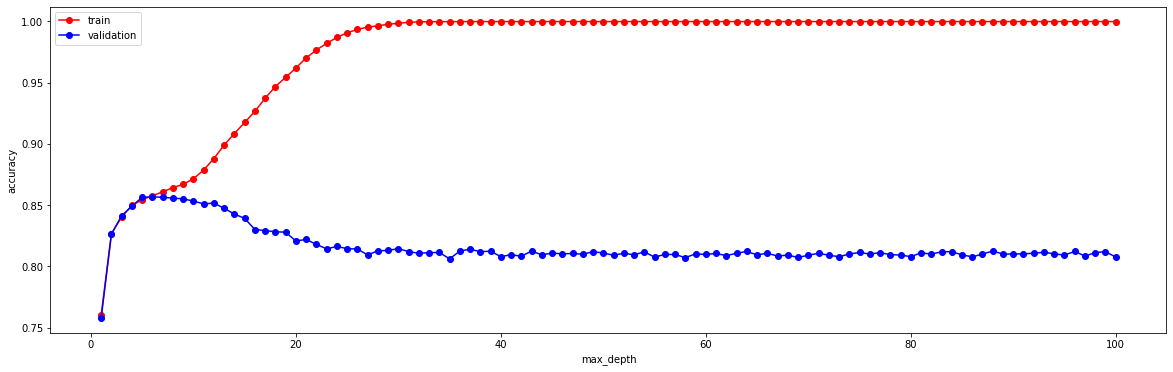

In [33]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,6))
plt.plot(depths, train_acc,'or-') #o: body, r: barva, -: spojení bodů linkou
plt.plot(depths, val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [34]:
optimal_depth = np.argmax(val_acc) + 1
optimal_depth

6

Spočítejme **testovací accuracy** pro nejlepší nalezenou hodnotu `max_depth`:

In [35]:
dt = DecisionTreeClassifier(max_depth=optimal_depth)
dt.fit(Xtrain, ytrain)
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (test): 0.849650


### Grid search: ladění více hyperparameterů

  * Chceme projít hodnoty `max_depth` z intervalu [1, 100] a obě možné hodnoty `criterion`, tj. 200 různých kombinací.
  * Můžeme samozřejmě použít dva vnořené for cykly (což je hrozné) nebo použít `ParameterGrid` balíček.

In [40]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'max_depth': range(1,30), # zase tady nemusime byt do noci...
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)
# just to see the result:
[param_comb[i] for i in range(30)]

[{'max_depth': 1, 'criterion': 'entropy'},
 {'max_depth': 2, 'criterion': 'entropy'},
 {'max_depth': 3, 'criterion': 'entropy'},
 {'max_depth': 4, 'criterion': 'entropy'},
 {'max_depth': 5, 'criterion': 'entropy'},
 {'max_depth': 6, 'criterion': 'entropy'},
 {'max_depth': 7, 'criterion': 'entropy'},
 {'max_depth': 8, 'criterion': 'entropy'},
 {'max_depth': 9, 'criterion': 'entropy'},
 {'max_depth': 10, 'criterion': 'entropy'},
 {'max_depth': 11, 'criterion': 'entropy'},
 {'max_depth': 12, 'criterion': 'entropy'},
 {'max_depth': 13, 'criterion': 'entropy'},
 {'max_depth': 14, 'criterion': 'entropy'},
 {'max_depth': 15, 'criterion': 'entropy'},
 {'max_depth': 16, 'criterion': 'entropy'},
 {'max_depth': 17, 'criterion': 'entropy'},
 {'max_depth': 18, 'criterion': 'entropy'},
 {'max_depth': 19, 'criterion': 'entropy'},
 {'max_depth': 20, 'criterion': 'entropy'},
 {'max_depth': 21, 'criterion': 'entropy'},
 {'max_depth': 22, 'criterion': 'entropy'},
 {'max_depth': 23, 'criterion': 'entropy'

In [41]:
val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))

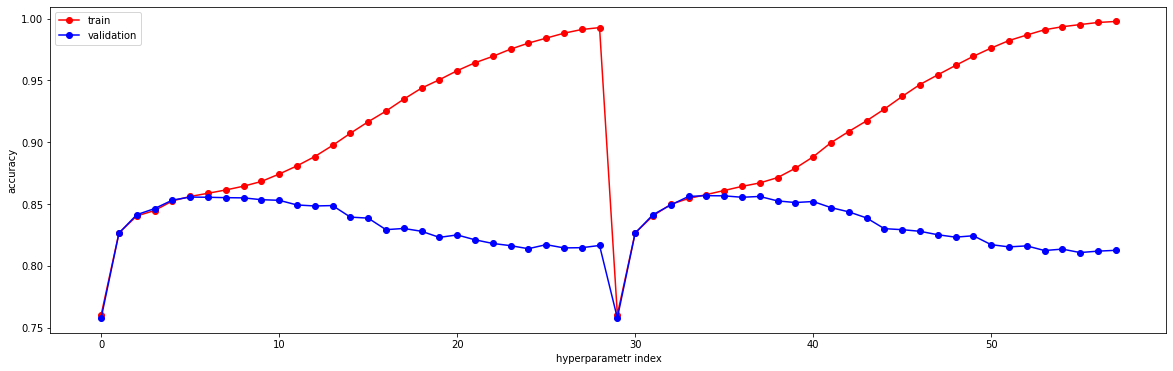

In [42]:
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('hyperparametr index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])

In [43]:
best_params = param_comb[np.argmax(val_acc)]
best_params

{'max_depth': 6, 'criterion': 'gini'}

In [44]:
dt = DecisionTreeClassifier(**best_params) # TOHOTO ŘÁDKU si všimněte: dvě hvězdišky jsou mocný nástroj
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))

accuracy score (train): 0.857712
accuracy score (validation): 0.856675
accuracy score (test): 0.849527


In [45]:
# ukázka operátoru **
def add(a=0, b=0):
    print(a + b)

d = {
    'a': 1,
    'b': -2
}

add(**d)

-1


# Jak vykreslit strom  

In [46]:
simple_data = pd.read_csv('simple_data.csv', sep=';') # data z přednášky
display(simple_data.head(16)) 
dts = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dts.fit(simple_data.iloc[:,1:],simple_data['T'])

T  F1  F2  F3
0  1   1   0   0
1  1   0   1   1
2  1   1   0   0
3  1   1   1   1
4  0   0   0   1
5  0   0   1   0
6  0   0   0   1
7  0   1   1   0

DecisionTreeClassifier(criterion='entropy', max_depth=2)

[Text(0.5, 0.8333333333333334, 'F1 <= 0.5\nentropy = 1.0\nsamples = 8\nvalue = [4, 4]\nclass = y[0]'),
 Text(0.25, 0.5, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [3, 1]\nclass = y[0]'),
 Text(0.125, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = y[0]'),
 Text(0.375, 0.16666666666666666, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]'),
 Text(0.75, 0.5, 'F2 <= 0.5\nentropy = 0.811\nsamples = 4\nvalue = [1, 3]\nclass = y[1]'),
 Text(0.625, 0.16666666666666666, 'entropy = 0.0\nsamples = 2\nvalue = [0, 2]\nclass = y[1]'),
 Text(0.875, 0.16666666666666666, 'entropy = 1.0\nsamples = 2\nvalue = [1, 1]\nclass = y[0]')]

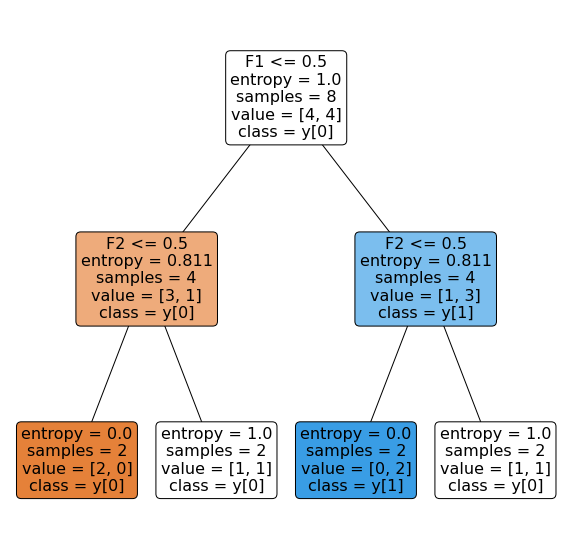

In [47]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(figsize=(10,10))
plot_tree(dts, filled=True, feature_names=simple_data.iloc[:,1:].columns, class_names=True, rounded=True)


#pro titanik
#plt.figure(figsize=(20,25))
#plot_tree(dt, filled=True, feature_names=Xdata.columns, class_names=["not survived", "survived"], rounded=True)

### ÚKOL: naučte strom na datech k Titaniku z minulého cvičení

  * Hyperparametry k tunění si vyberte sami.
  * Rozdělte data ve stejných poměrech a se stejným `random_state` v metode `train_test_split()` jeko výše.

Survived  Pclass     Sex  FootSize   Age  SibSp  Parch            Ticket  \
0         1       1  female      34.0  33.0      0      0            110152   
1         0       3    male       NaN   NaN      0      0            358585   
2         0       3    male       NaN  41.0      0      0  SOTON/O2 3101272   
3         1       3    male       NaN  20.0      0      0              2663   
4         1       1  female       NaN  36.0      1      2            113760   

        Fare    Cabin Embarked  
0    86.5000      B77        S  
1    14.5000      NaN        S  
2  7125.0000      NaN        S  
3     7.2292      NaN        C  
4   120.0000  B96 B98        S

Survived  Pclass  Sex  FootSize   Age  SibSp  Parch  Ticket       Fare  \
0         1       1    0      34.0  33.0      0      0       0    86.5000   
1         0       3    1       NaN   NaN      0      0      81    14.5000   
2         0       3    1       NaN  41.0      0      0     118  7125.0000   
3         1       3    1       NaN  20.0      0      0      38     7.2292   
4         1       1    0       NaN  36.0      1      2       9   120.0000   

   Cabin  Embarked  
0      9         2  
1     -1         2  
2     -1         2  
3     -1         0  
4     11         2

Survived  Pclass  Sex  FootSize   Age  SibSp  Parch  Ticket       Fare  \
0         1       1    0      34.0  33.0      0      0       0    86.5000   
1         0       3    1      -1.0  -1.0      0      0      81    14.5000   
2         0       3    1      -1.0  41.0      0      0     118  7125.0000   
3         1       3    1      -1.0  20.0      0      0      38     7.2292   
4         1       1    0      -1.0  36.0      1      2       9   120.0000   

   Cabin  Embarked  
0      9         2  
1     -1         2  
2     -1         2  
3     -1         0  
4     11         2

best params  {'max_depth': 7, 'criterion': 'gini'}
accuracy score (train): 0.986486
accuracy score (validation): 0.920000
accuracy score (test): 0.727273


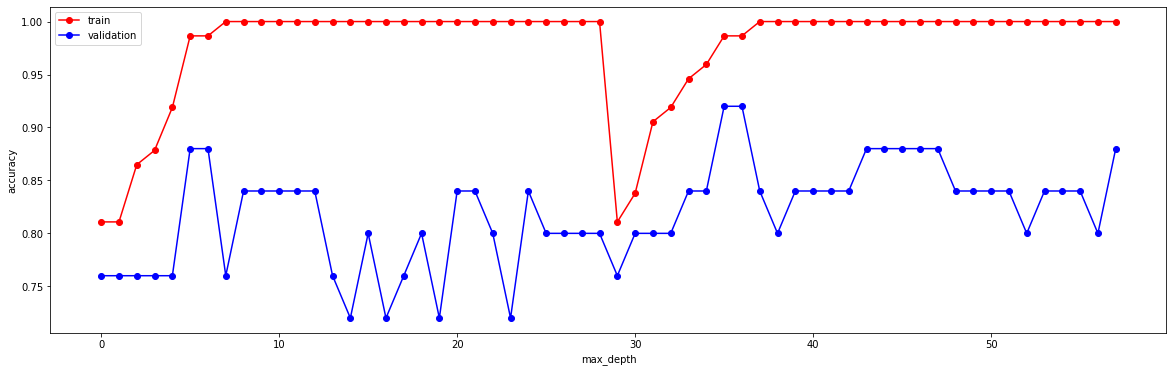

In [48]:
titanic = pd.read_csv('titanic.csv', sep=';')
### sem přijde Váš kód
titanic.nunique()
#  #unikátních hodnot = #řádků
titanic.drop(columns=["Name", "PassengerId"], inplace=True) # ty asi nemaji moc smysl...
display(titanic.head())

# kategorie
string_cols = titanic.select_dtypes(['object']).columns # string --> cislelne kategorie
titanic[string_cols] = titanic[string_cols].astype('category').apply(lambda x: x.cat.codes)
display(titanic.head())

# nahrazení nans
titanic = titanic.replace(np.nan, -1)
display(titanic.head())

# rozsekání dat
Xdata = titanic.iloc[:,1:]
ydata = titanic.iloc[:,0]

# copy paste
rd_seed = 333 # data jsou rozdělována náhodně, v rámci testování je ale dobré mít pevně daný random seed
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.25, random_state=rd_seed) 
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.25, random_state=rd_seed) 
param_grid = {
    'max_depth': range(1,30), 
    'criterion': ['entropy', 'gini']
}
param_comb = ParameterGrid(param_grid)

val_acc = []
train_acc = []
for params in param_comb:
    dt = DecisionTreeClassifier(max_depth=params['max_depth'], criterion=params['criterion'])
    dt.fit(Xtrain, ytrain)
    train_acc.append(metrics.accuracy_score(ytrain, dt.predict(Xtrain)))
    val_acc.append(metrics.accuracy_score(yval, dt.predict(Xval)))
plt.figure(figsize=(20,6))
plt.plot(train_acc,'or-')
plt.plot(val_acc,'ob-')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
best_params = param_comb[np.argmax(val_acc)]
print('best params ', best_params)
dt = DecisionTreeClassifier(max_depth=best_params['max_depth'], criterion=best_params['criterion'])
dt.fit(Xtrain, ytrain)
print('accuracy score (train): {0:.6f}'.format(metrics.accuracy_score(ytrain, dt.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(metrics.accuracy_score(yval, dt.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(metrics.accuracy_score(ytest, dt.predict(Xtest))))